# Test Sampling Without Replacement

Do the algorithms work? Are they non-biased? and how fast are they?

Algorithms:
  * Reservoir algorithm R
  * Reservoir algorithm L
  * Fisher Yates
  * Hidden shuffle 
     


In [1]:
import gfort2py as gf
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_frequency(m_samples, n_range, occurrences):
    # Uniform probability of getting each value
    uniform_p = m_samples / n_range
    normalize =  1. / (n_repeat * uniform_p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_range + 1), occurrences[1:] * normalize)
    plt.xlabel('Value')
    plt.ylabel('Normalised Frequency of Selection')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_range + 1), (occurrences[1:] * normalize) - 1)
    plt.xlabel('Value')
    plt.axhline(y=0.0, color='r', linestyle='--', label=f'Normalised Expected Frequency') 
    plt.legend()
    plt.ylabel('Normalised Frequency of Selection')
    plt.show()
    

def report_largest_deviations(m_samples, n_range, occurrences, n_report=10):
    uniform_p = m_samples / n_range
    normalize =  1. / (n_repeat * uniform_p)
    
    # Ignore element 0, which wil not indexed by fortran
    occurrences_ = occurrences[1:]
    recentred_occurrences = (occurrences_ * normalize) - 1
    indices = np.argsort(np.abs(recentred_occurrences))
    
    print(f"Top {n_report} values that deviate from the expected normalised value of 1.0:")
    for i in indices[-n_report:][::-1]:
        print(i, occurrences_[i] * normalize)



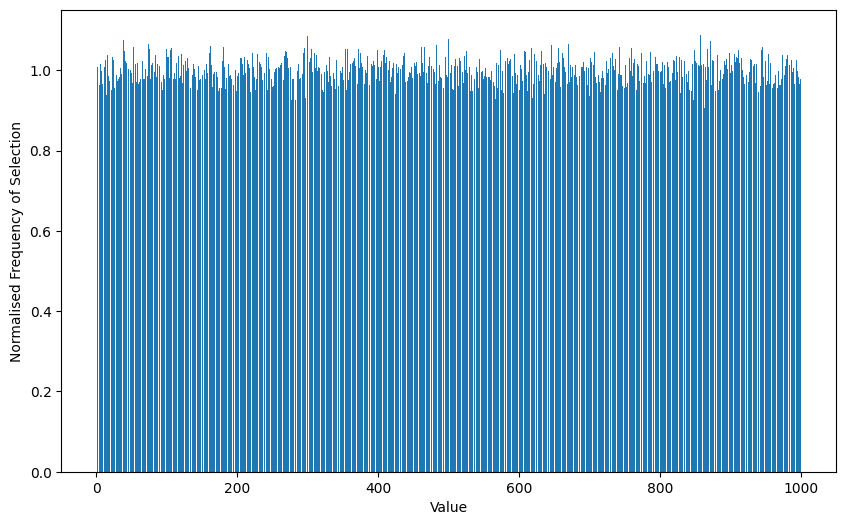

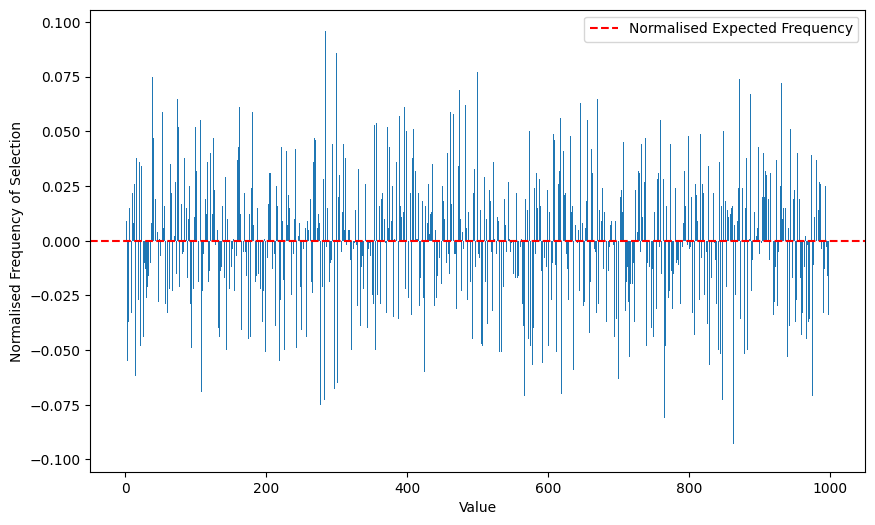

Top 10 values that deviate from the expected normalised value of 1.0:
283 1.096
132 0.904
862 0.907
826 1.088
857 1.088
299 1.086
843 0.917
477 1.082
764 0.919
623 1.081


In [123]:
""" Simple Reservoir Sampling

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    for j in result.args['selected']:
        occurrences[j] += 1

plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)


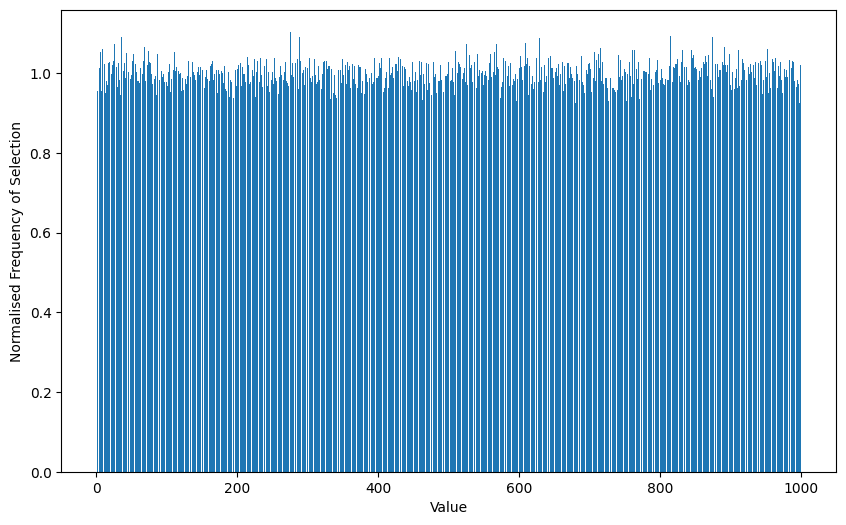

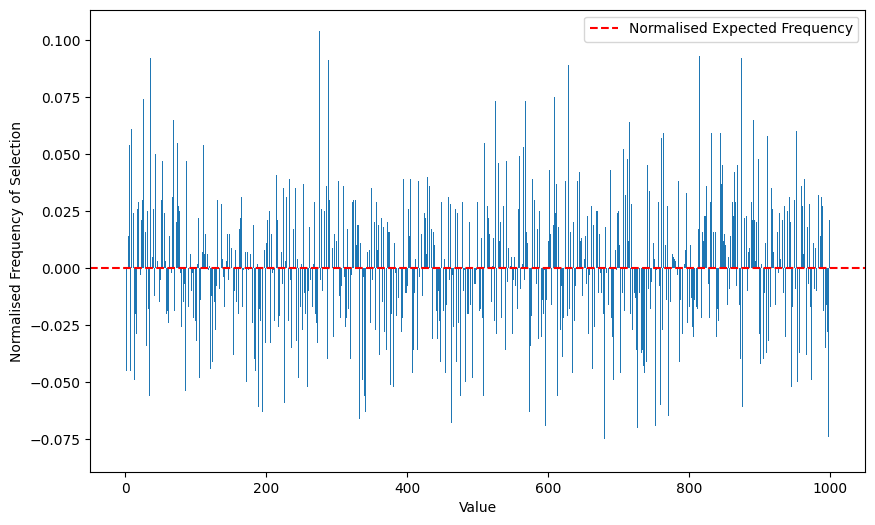

Top 10 values that deviate from the expected normalised value of 1.0:
275 1.104
814 1.093
874 1.092
35 1.092
551 1.091
288 1.091
628 1.089
236 1.087
944 1.086
700 1.084


In [124]:
""" Reservoir Sampling using Algorithm L.

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling_algorithml(m_samples, n_range, seeds, np.empty(shape=(m_samples)))
    # Fill counts
    for j in result.args['reservoir']:
        occurrences[j] += 1
        
plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)



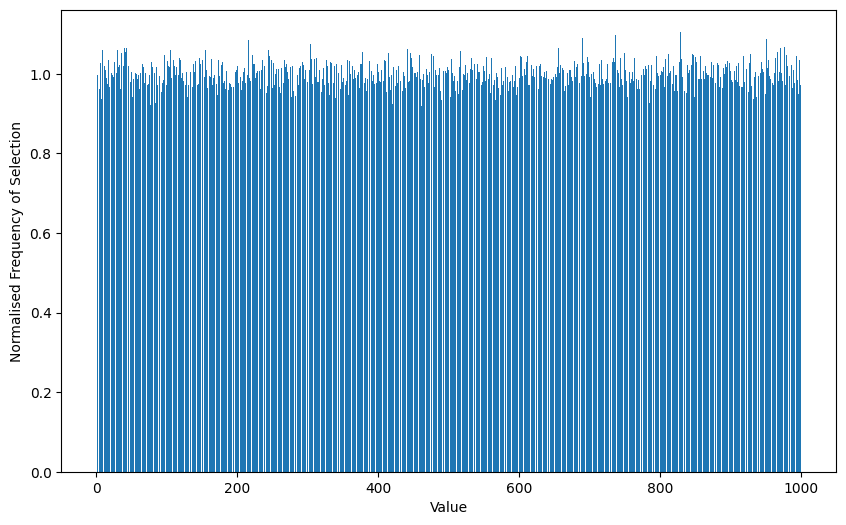

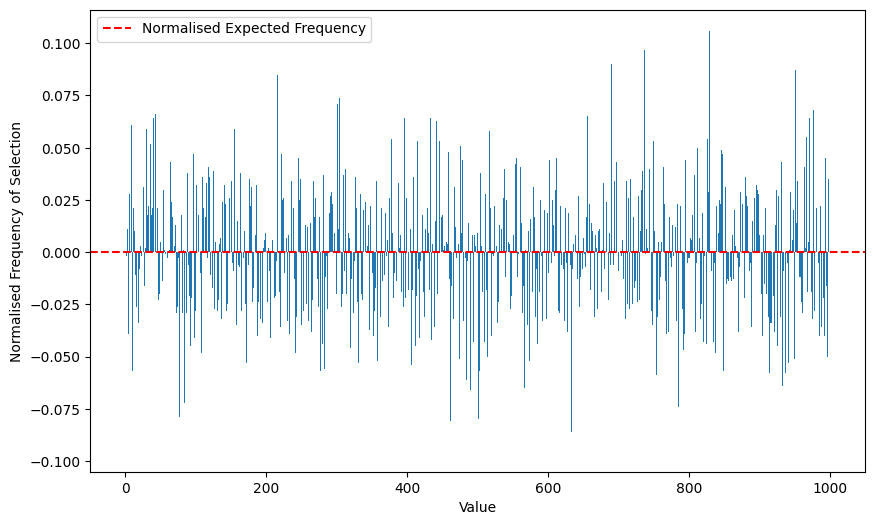

Top 10 values that deviate from the expected normalised value of 1.0:
828 1.106
667 1.1
736 1.097
338 0.905
689 1.09
165 0.913
950 1.087
30 1.086
632 0.914
215 1.085


In [125]:
""" Fisher-Yates Shuffle
"""
fy_shuffle_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/fisher_yates_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)
seed = int.from_bytes(os.urandom(16), 'big') 

for i in range(0, n_repeat):
    result = fy_shuffle_m.fisher_yates_shuffle(m_samples, n_range, seed, np.empty(shape=(m_samples)))
    seed = result.args['seed']
    for j in result.args['values']:
        occurrences[j] += 1
        
plot_frequency(m_samples, n_range, occurrences)
report_largest_deviations(m_samples, n_range, occurrences)


In [109]:
"""Hidden Shuffle

Appears to be an implementation error? Certainly returning the same erroneous number for the last element of some iterations

For a much large sample size  with larger range, it also throws up two erroneous iterations for the last 9 values
"""
hidden_shuffle_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/hidden_shuffle_m.mod')

m_samples = 10
n_range = 100
n_repeat = 100
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = hidden_shuffle_m. hidden_shuffle(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    try:
        for j in result.args['result']:
            occurrences[j] += 1
    except IndexError:
        print(f'Index error on iteration {i}')
        print(result.args['result'])


print('Asking for more samples, from a larger range')
m_samples = 1000
n_range = 100000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = hidden_shuffle_m. hidden_shuffle(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    try:
        for j in result.args['result']:
            occurrences[j] += 1
    except IndexError:
        print(f'Index error on iteration {i}')
        print(result.args['result'])


# Plotting takes 30-60 secs with this volume of data
plot_me = False

# Uniform probability of getting each value
if plot_me:
    plot_frequency(m_samples, n_range, occurrences)


Asking for more samples, from a larger range
Index error on iteration 177
[         8         91        123        196        224        267
        379        513        531        532        634       1376
       1472       1736       1921       1939       2044       2174
       2266       2757       2767       2940       3044       3089
       3116       3354       3428       3464       3495       3671
       3779       3790       3809       3820       3956       3995
       4041       4080       4159       4364       4407       4601
       4852       4935       5056       5064       5243       5251
       5281       5399       5668       5749       5812       5864
       5947       6005       6020       6309       6364       6497
       6504       6594       6729       6730       6735       6861
       6883       6931       6932       7062       7401       7467
       7712       7856       7872       7912       7956       7995
       8052       8208       8423       8537       8666

In [7]:
""" Reservoir sampling Algorithm L with weight
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 30
n_range = 1000
n_repeat = 1000

# Create a hat function
weights = np.zeros(shape=n_range)
weights[10:50] = 1
threshold = 1.e-5

# Expect the m samples to be drawn from the indices [10:50]
# Can this pull in duplicates? Yes, was very clear. Should implement
# [Weighted random sampling with a reservoir](https://doi.org/10.1016/j.ipl.2005.11.003)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling_algorithml_with_weight(m_samples, 
                                                                   n_range, 
                                                                   seeds, 
                                                                   weights, 
                                                                   threshold,
                                                                   np.empty(shape=(m_samples))
                                                                   )
    reservoir = result.args['reservoir']
    unique, counter = np.unique(reservoir, return_counts=True)
    if np.any(counter > 1):
        print(f'Produced duplicate in iteration {i}')
        print(unique[counter > 1])
    




Produced duplicate in iteration 0
[20 24 28 31 37 43 44]
Produced duplicate in iteration 1
[12 24 35 44 47 48 49 50]
Produced duplicate in iteration 2
[13 23 34 45 46 49]
Produced duplicate in iteration 3
[24 37 41 42 43 44 47]
Produced duplicate in iteration 4
[31 33 37 39 47 50]
Produced duplicate in iteration 5
[11 21 31 33 36 44 48]
Produced duplicate in iteration 6
[20 23 33 38 39 44 46]
Produced duplicate in iteration 7
[11 35 38 39 42 46]
Produced duplicate in iteration 8
[17 27 31 37 39 41 44 45]
Produced duplicate in iteration 9
[29 33 38 40 41 43 46]
Produced duplicate in iteration 10
[29 31 34 37 40 41 44 49]
Produced duplicate in iteration 11
[28 35 37 39 43 47 49 50]
Produced duplicate in iteration 12
[34 36 46]
Produced duplicate in iteration 13
[31 33 41 47 50]
Produced duplicate in iteration 14
[20 32 36 40 41 43 45]
Produced duplicate in iteration 15
[13 35 36 39 46]
Produced duplicate in iteration 16
[15 21 40]
Produced duplicate in iteration 17
[19 37 48 50]
Produced